# **CUSTOMER SEGMENTATION**

## STEP 1


**IMPORTING LIBRARIES**

In [127]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt
######
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import cut_tree
from scipy.cluster.hierarchy import dendrogram

# can be writeen as:
#from scipy.cluster.hierarchy import linkage,dendrogram,cut_tree

**LOADING DATA FROM DRIVE**

In [128]:
data=pd.read_csv('/content/drive/My Drive/data/OnlineRetail.csv',sep=",", encoding="ISO-8859-1", header=0)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


**VIEWING/ANALYING DATA**

In [129]:
data.shape  # 541909 rows, 8 columns

(541909, 8)

In [130]:
data.info()  # it shows that cloumns Description, and CustomerID has some missing values as they are less than 541909

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [131]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# STEP 2

**DATA CLEANING i.e. CHECKING AND REMOVING NAN VALUES**

In [132]:
 # calculating percentage of missing values. Its not necessary as we have already found 
 # it in the previous step.this is the formula for fing % of null values in every column.
 df_null=round(100*data.isnull().sum())/len(data),2
 df_null  # In Description 0.26% data is missing while in CustomerID 24.92% data is missing

(InvoiceNo       0.000000
 StockCode       0.000000
 Description     0.268311
 Quantity        0.000000
 InvoiceDate     0.000000
 UnitPrice       0.000000
 CustomerID     24.926694
 Country         0.000000
 dtype: float64, 2)

In [133]:
# now dropping missing values rows
data=data.dropna()
# checking the shape(no. or rows and cols) again to find out how mant rows are dropped
data.shape  #shows that out of 541909 rows, there are now only 40829 rows.remaining rows are dropped


(406829, 8)

In [134]:
# Changing the column CustomerID type to String
data['CustomerID']=data['CustomerID'].astype(str)

# STEP 3: 
**PREPARING DATA**


WE HAVE TO FIND 3 THINGS THAT ARE **"RFM"**

1) **R (Recency)**: Number of days since last purchase

2) **F (Frequency)**: Number of tracsactions

3) **M (Monetary)**: Total amount of transactions (revenue contributed)


1) **MONETARY(M)**

In [135]:
# creating a new column amount
data['Money']=data['Quantity'] * data['UnitPrice']

#grouping this column (amount) with CustomerID 
# Sum is done to find how much each customer spend
rfm_m = data.groupby('CustomerID')['Money'].sum()

# reseting index
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Money
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


2) **FREQUENCY(F)**

In [136]:
#grouping the column (InvoiceNo) with CustomerID to find frequency 
# count is done to find how many times each customer comes
rfm_f = data.groupby('CustomerID')['InvoiceNo'].count()

# reindexing
rfm_f=rfm_f.reset_index()

# giving names to columns
rfm_f.columns=['CustomerID','Frequency']
rfm_f.head()



,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


**MERGING COLUMNS "Money" AND "Frequency" W.R.T. "CustomerID"**

In [137]:
rfm_m_f=pd.merge(rfm_m,rfm_f,on='CustomerID',how='inner')
rfm_m_f.head()

,CustomerID,Money,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


3) **RECENCY (R)**

In [138]:
# Changing date time format to standard so that machine can recognise it as date
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'],format='%d-%m-%Y %H:%M')

#finding the max (last) date for inding recency
last_date = max(data['InvoiceDate'])
last_date  #shows that last date was 2011-12-09

Timestamp('2011-12-09 12:50:00')

In [139]:
# finding the difference between the last date and last puchase by creating column "Recency"
data['Recency'] = last_date - data['InvoiceDate']

# grouping this new generated column (Recency) with CustomerID
# min is done to find the last time customer visited
rfm_r = data.groupby('CustomerID')['Recency'].min()

# reindexing
rfm_r = rfm_r.reset_index()
rfm_r.head()

,CustomerID,Recency
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [140]:
# extracting only days in Diff column for 

rfm_r['Recency'] = rfm_r['Recency'].dt.days
rfm_r.head()

,CustomerID,Recency
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


**MERGING "rfm_m_f" with "rfm_r"**

In [141]:
rfm = pd.merge(rfm_m_f,rfm_r,on='CustomerID',how='inner')
rfm.head()

,CustomerID,Money,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


**VISUALIZING DATA TO FIND OUTLIERS**

Text(0, 0.5, 'Outliers')

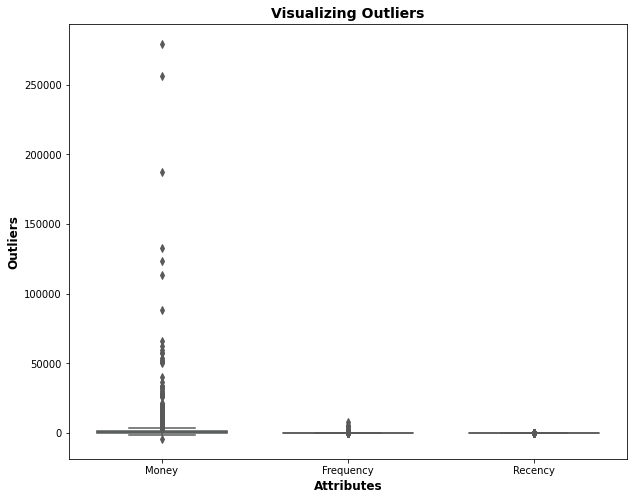

In [142]:
attributes = ['Money','Frequency',"Recency"]
plt.rcParams['figure.figsize'] = [10,8] # [width,height] each point is of 72 pixel

sns.boxplot(data=rfm[attributes],orient='v',palette="Set2", whis=1.5,saturation=1,width=0.7)
plt.title('Visualizing Outliers',fontsize=14 , fontweight='bold')
plt.xlabel('Attributes',fontsize=12 , fontweight='bold')
plt.ylabel('Outliers',fontsize=12 , fontweight='bold')


**FINDING IQR (INTER QUARANTILE RANGE) FOR ELIMINATING OUTLIERS**


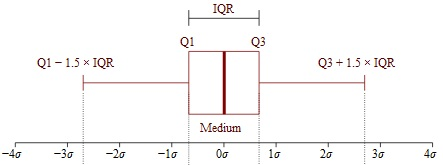

In [143]:
# Removing statistical outliers from Money column
Q1= rfm.Money.quantile(0.05)
Q3= rfm.Money.quantile(0.95)
IQR = Q3 - Q1
rfm= rfm[(rfm.Money >= Q1-1.5*IQR) & (rfm.Money <= Q3+1.5*IQR)]

# Removing statistical outliers from Frequency column
Q1= rfm.Frequency.quantile(0.05)
Q3= rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm= rfm[(rfm.Frequency >= Q1-1.5*IQR) & (rfm.Frequency <= Q3+1.5*IQR)]

# Removing statistical outliers from Recency column
Q1= rfm.Recency.quantile(0.05)
Q3= rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm= rfm[(rfm.Recency >= Q1-1.5*IQR) & (rfm.Recency <= Q3+1.5*IQR)]



**SCALING BY USING STANDARD SCALING TECHNIQUE**

In [144]:
rfm_df= rfm[['Money','Frequency','Recency']]
scalar= StandardScaler()
rfm_df_scaled= scalar.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [145]:
# Converting it into DataFrame
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Money', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Money,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


# STEP 4:

**BUILDING THE MODEL BY TWO METHODS**

1) K MEANS CLUSTING

2) HIERARCHIAL CLUSTERING

1) **K MEANS CLUSTERING**

In [146]:
kmeans = KMeans(n_clusters=4,max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [147]:
kmeans.labels_

array([2, 3, 0, ..., 2, 0, 0], dtype=int32)

**Finding optimal value for K means.**
_______________________________________________
**We have 2 methods to find optimal K vlaue.**

1) **Elbow Curve**

2) **Silhouette Analysis** 

**1) ELBOW CURVE**

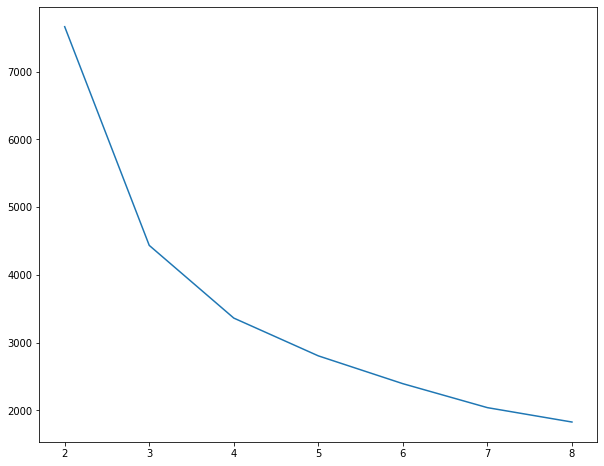

In [148]:
ssd=[]
range_clusters=[2,3,4,5,6,7,8]
for i in range_clusters:
  kmeans=KMeans(n_clusters=i, max_iter=50)
  kmeans.fit(rfm_df_scaled)
  ssd.append(kmeans.inertia_)

plt.plot(range_clusters,ssd)  # shows we are getting elbow at "3" on x-axis, so  can be optimal K value

2)**SILHOUTTE ANALYSIS**


image.png

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

The value of the silhouette score range lies between -1 to 1.

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.




In [151]:
range_clusters= [2,3,4,5,6,7,8]
for i in range_clusters:
  kmeans=KMeans(n_clusters=i,max_iter=50)
  kmeans.fit(rfm_df_scaled)
  cluster_labels=kmeans.labels_
  silhouette_avg= silhouette_score(rfm_df_scaled,cluster_labels)
  print('for n_clusters={0}, the silhoutte score is : {1}'.format(i,silhouette_avg))
# here max values are at 2 and , so we may take optimal K value as 2 or 3

for n_clusters=2, the silhoutte score is : 0.5415858652525395
for n_clusters=3, the silhoutte score is : 0.5084896296141937
for n_clusters=4, the silhoutte score is : 0.4781841150952288
for n_clusters=5, the silhoutte score is : 0.4662700564189704
for n_clusters=6, the silhoutte score is : 0.41742250872395564
for n_clusters=7, the silhoutte score is : 0.4149333347620585
for n_clusters=8, the silhoutte score is : 0.4093848755532677


**FINALLY FITTING MODEL AGAIN WITH OPTIMAL VALUE K=3**

In [152]:
kmeans=KMeans(n_clusters=3 , max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [153]:
kmeans.labels_

array([2, 0, 1, ..., 2, 1, 1], dtype=int32)

**CREATING A NEW COLUMN "CLUSTER_ID" IN rfm** (result OF K-MEANS clustering)

In [154]:
rfm['Cluster_ID'] = kmeans.labels_
rfm.head()

,CustomerID,Money,Frequency,Recency,Cluster_ID
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,2


# **VISUALIZING RESULTS OF K-MEANS CLUSTERING**

**CLUSTER_ID vs MONEY**

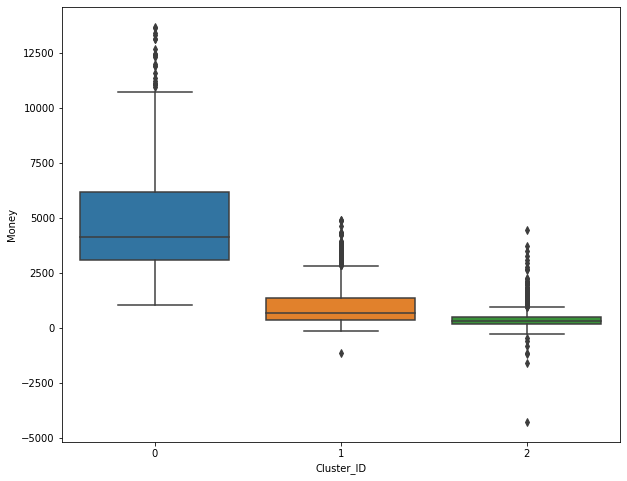

In [155]:
sns.boxplot(x= 'Cluster_ID',y='Money',data=rfm)
# shows that customers in cluster 0 have spend most money

**CLUSTER_ID vs FREQUENCY**

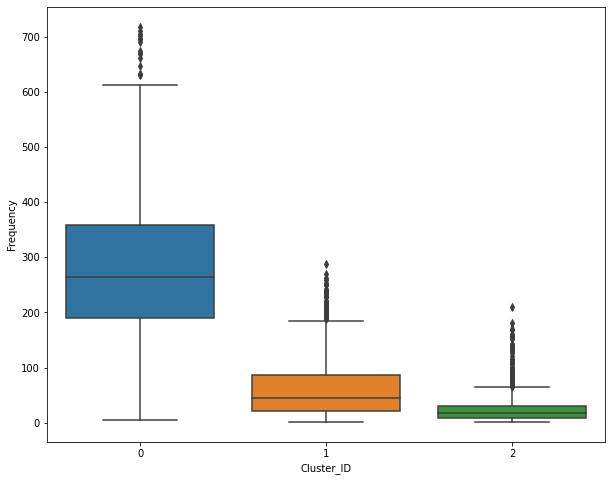

In [156]:
sns.boxplot(x='Cluster_ID',y='Frequency',data=rfm)
# shows that customers in cluster 0 have come frequently to shop 

**CLUSTER_ID vs RECENCY**

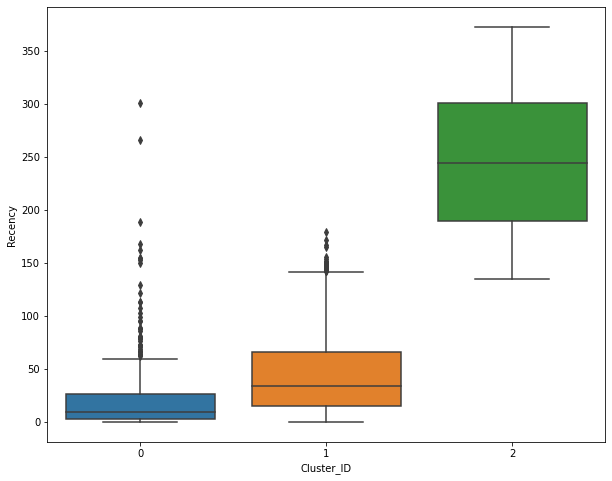

In [157]:
sns.boxplot(x='Cluster_ID',y='Recency',data=rfm)
#shows that customers in cluster 0 have low value that is the are recent buyers

# **2) HIERARCHAL CLUSTERING**

**IN THIS WE HAVE 3 TECHNIQUES**

**1) SINGLE LINKAGE**

**2) COMPLETE LINKAGE (BEST FOR USE)**

**3)AVERAGE LINKAGE**

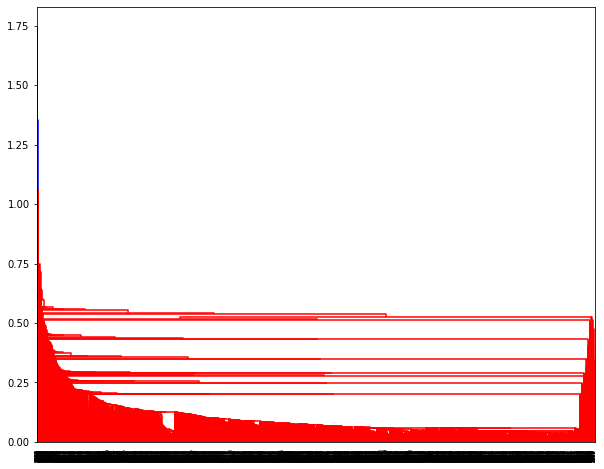

In [159]:
# SINGLE LINKAGE 
mergings = linkage(rfm_df_scaled,method='single',metric='euclidean')
dendrogram(mergings)
plt.show()
# shows very clumpsy plot.Can't find number of clusters from here

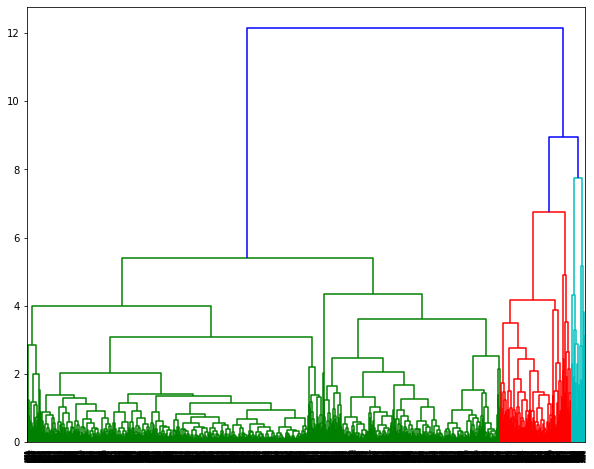

In [161]:
# COMPLETE LINKAGE
mergings=linkage(rfm_df_scaled,method='complete',metric='euclidean')
dendrogram(mergings)
plt.show()

#shows clear plot. We can see 3 colors dendrogram indicating 3 clusters of green, red and blue

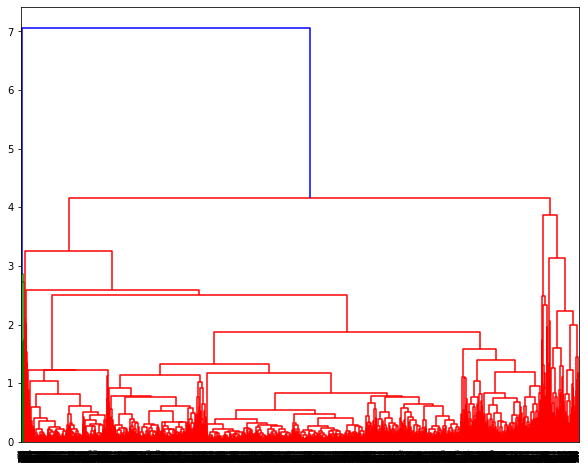

In [162]:
# AVERAGE LINKAGE
mergings=linkage(rfm_df_scaled,method='average',metric='euclidean')
dendrogram(mergings)
plt.show()

**CUTTING THE DENDROGRAM BASED ON K**

In [163]:
cluster_labels=cut_tree(mergings,n_clusters=3).reshape(-1,)
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

**CREATING COLUMN OF "CLUSTER_LABELS" IN rfm** (result of hierarchial clustering)

In [164]:
rfm['Cluster_Labels']=cluster_labels
rfm.head()

,CustomerID,Money,Frequency,Recency,Cluster_ID,Cluster_Labels
0,12346.0,0.00,2,325,2,0
1,12347.0,4310.00,182,1,0,0
2,12348.0,1797.24,31,74,1,0
3,12349.0,1757.55,73,18,1,0
4,12350.0,334.40,17,309,2,0


# **VISUALIZING RESULTS OF HIERARCHICAL CLUSTERING**

**CLUSTER_LABEL vs MONEY**

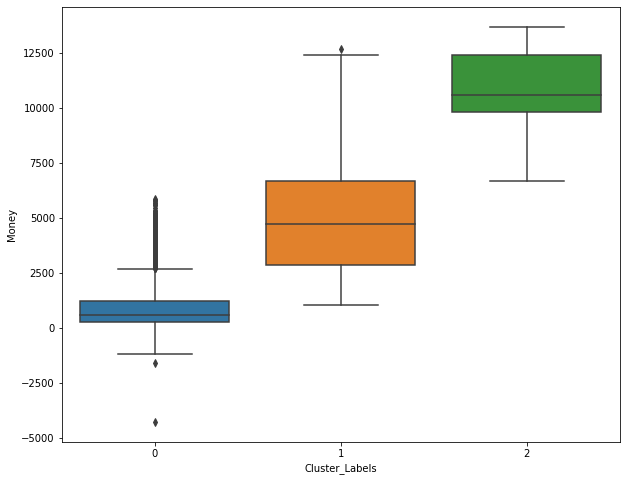

In [165]:
sns.boxplot(x='Cluster_Labels', y='Money', data=rfm)
#shows that customers in cluster 2 have spend more money

**CLUSTER_LABEL vs FREQUENCY**

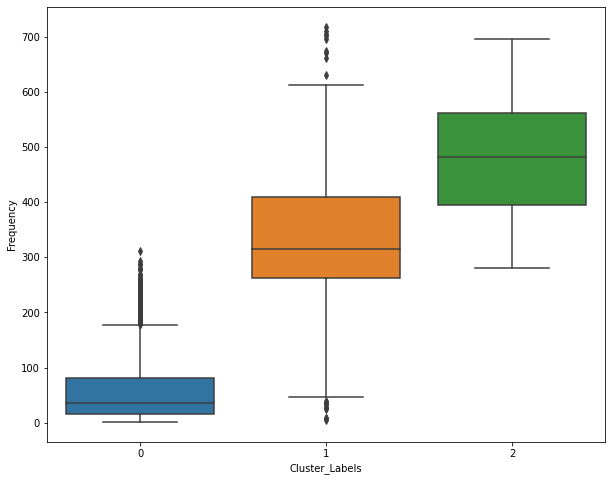

In [167]:
sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)
# shows that customers in cluster 2 have visited store frquently

**CLUSTER_LABEL vs RECENCY**

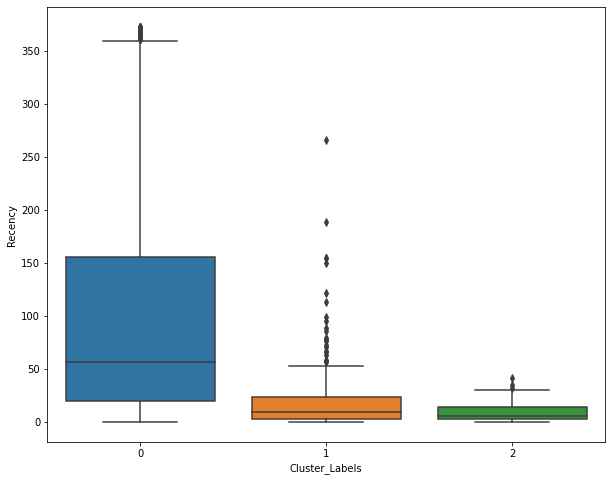

In [168]:
sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)
# shows that customers in cluster 2 have low date difference i.e. they are recent buyers

#**FINAL ANALYSIS:**
 **BY USING K-MEANS CLUSTERING**

 CUSTOMERS OF CLUSTER 0 HAVE GENERATED MORE REVENUE FOR THE STORE 


 **BY USING HIERARCHAL CLUSTERING**
 
 CUSTOMERS OF CLUSTER 2 HAVE GENERATED MORE REVENUE FOR THE STORE 

